##  Important Rules
**Insert team member names here:**

**Rename this notebook with your MIDAS username as the prefix**

**Choose "Restart Kernel and Run All Cells ..." under "Kernel" before submitting your final notebook**


**Report your Pareto Score: Nov 25**

**Due date of final: December 3rd, 11:59pm**

## Final Project - Fine-tuning and Transfer Learning on Caltech-101 with Model Size and Accuracy Trade-offs

The goal of this project is to classify images from the Caltech-101 dataset using fine-tuning and transfer learning while exploring the trade-offs between accuracy and model size. The dataset includes images from 101 categories, making it a moderately challenging classification task. Given the relatively small dataset size, we will leverage pretrained CNNs for feature extraction, comparing their performance in terms of both accuracy and model size.

### Key Steps:
#### Data Preprocessing:

The Caltech-101 images will be resized, normalized, and split into training, validation, and test sets. Data augmentation techniques may be applied to mitigate overfitting.

#### Transfer Learning:
Three different pretrained models with varying sizes and complexities need to be used: each team can choose which three

For each model, the convolutional layers will be frozen to use their pretrained features, and only the top fully connected layers will be fine-tuned for the Caltech-101 task. For transfer learning, all weights should be trained.

#### Model Training:
The models will be trained using the Caltech-101 dataset.
Techniques such as learning rate scheduling, early stopping, and data augmentation can be applied.
Each model’s training time, accuracy, and memory usage will be monitored to analyze the trade-offs.

#### Trade-off Analysis:
Using the same test dataset, the final accuracy should be computed. Each team should use the same routine to fine-tune and transfer learning three different models. And compare the accuracy vs model sizes. The teams with overall Pareto trade-off will get extra credit.

### Details
1. Implement dataloaders for train (70%), validation (15%) and testing (15%) of caltech101
2. Implement visualization routines to show image, ground truth and predicted labels       
3. Implement fine-tuning routine, using pretrained weights from Pytorch                    
4. Implement transfer learning routine, using pretrained weights                           
5. Use hyperparameter tuning to achieve good accuracy, using validation datasets           
6. GPU must be used                                                                        
7. Conduct experiment at least *3 (three) * pretrained models.                          
8. (Extra credit) The top 3 teams with best accuracy-model size Pareto scores (<0.088) get extra credit

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math
from torch.utils.data import DataLoader, random_split
import torchvision.utils as utils # Added this import

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import os

In [2]:
#!pip install --upgrade torchvision

In [3]:
import torchvision
import torchvision.datasets as datasets
dir(torchvision.datasets)


['CIFAR10',
 'CIFAR100',
 'CLEVRClassification',
 'CREStereo',
 'Caltech101',
 'Caltech256',
 'CarlaStereo',
 'CelebA',
 'Cityscapes',
 'CocoCaptions',
 'CocoDetection',
 'Country211',
 'DTD',
 'DatasetFolder',
 'EMNIST',
 'ETH3DStereo',
 'EuroSAT',
 'FER2013',
 'FGVCAircraft',
 'FakeData',
 'FallingThingsStereo',
 'FashionMNIST',
 'Flickr30k',
 'Flickr8k',
 'Flowers102',
 'FlyingChairs',
 'FlyingThings3D',
 'Food101',
 'GTSRB',
 'HD1K',
 'HMDB51',
 'INaturalist',
 'ImageFolder',
 'ImageNet',
 'Imagenette',
 'InStereo2k',
 'KMNIST',
 'Kinetics',
 'Kitti',
 'Kitti2012Stereo',
 'Kitti2015Stereo',
 'KittiFlow',
 'LFWPairs',
 'LFWPeople',
 'LSUN',
 'LSUNClass',
 'MNIST',
 'Middlebury2014Stereo',
 'MovingMNIST',
 'Omniglot',
 'OxfordIIITPet',
 'PCAM',
 'PhotoTour',
 'Places365',
 'QMNIST',
 'RenderedSST2',
 'SBDataset',
 'SBU',
 'SEMEION',
 'STL10',
 'SUN397',
 'SVHN',
 'SceneFlowStereo',
 'Sintel',
 'SintelStereo',
 'StanfordCars',
 'UCF101',
 'USPS',
 'VOCDetection',
 'VOCSegmentation',
 

**This is important: you want to use the common normalization vector from imageNet. Since pretrained weights are based on ImageNet**

In [4]:
imagenet_mean=[0.485, 0.456, 0.406]
imagenet_std=[0.229, 0.224, 0.225]

In [5]:
## routine to print stats of a model
def print_model_weight_stats(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    print("{}: Number of fronzen param = {:,d}, number of trainable param = {:,}".format(type(model),frozen_params, trainable_params))

## calculate the pareto value
def compute_pareto_value(acc, msize):
    ## accuracy must be between 0.0 and 0.9999
    ## model size should be in millions, between 1.0 and 900!
    if not ( 0.0 <= acc <= 0.9999):
        raise ValueError ("acc range must be between 0.0 and 0.9999")

    if not (1.0 <= msize <= 900):
        raise ValueError("model sizse must be in millions, between 1.0M and 900M")

    xdist = 0.99 - acc
    ydist = math.log10( np.float64(msize) )

    # assumption: range of accuracy is between 0.99 to 0.80 -> delta 0.2
    # range of model is from 1M to 100M -> delta 2 after taking log
    # hence scale model by 0.1
    ydist = 0.1*ydist

    z_score = math.sqrt( xdist*xdist + ydist*ydist)
    return (z_score)

## use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print("torch version:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)

cuda
torch version: 2.9.1+cu128
torch.version.cuda: 12.8


In [6]:
## routines

## Your code here


In [7]:
## now do some work
## example: dataset = datasets.Caltech101(root='./data', download=True, transform=transform)
'''transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for models like ResNet
    transforms.Lambda(lambda image: image.convert("RGB")), # Ensure 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean,
                         std=imagenet_std)
])

dataset = datasets.Caltech101(root="./data",download=True, transform=transform)
classes = dataset.categories'''

import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For fully deterministic behavior:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # For DataLoader workers
    def _worker_init(worker_id):
        worker_seed = seed + worker_id
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    return _worker_init
worker_init_fn = seed_everything(42)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])
dataset = datasets.Caltech101(root='./data', download=True, transform=transform)
classes = dataset.categories

In [8]:
val_size = int(0.15 * len(dataset))
test_size = val_size
train_size = len(dataset) - val_size - test_size

In [9]:
# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_indices = train_dataset.indices
val_indices = val_dataset.indices
test_indices = test_dataset.indices
print(f"data shape: {train_dataset[0][0].shape}, val_data shape: {val_dataset[0][0].shape}, test_data shape: {test_dataset[0][0].shape}")
print(f"train indices: {train_indices[:10]}, val indices: {val_indices[:10]}, test indices: {test_indices[:10]}")


'''
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Training and test sets
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                         download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                        download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=200,
                                         shuffle=False, num_workers=2)'''


data shape: torch.Size([3, 224, 224]), val_data shape: torch.Size([3, 224, 224]), test_data shape: torch.Size([3, 224, 224])
train indices: [8512, 5748, 7753, 4345, 5587, 2508, 6996, 1701, 7265, 6578], val indices: [7238, 5821, 6650, 3146, 5412, 612, 3805, 3633, 2270, 5943], test indices: [2171, 4849, 8676, 6096, 5089, 7119, 3279, 7730, 8263, 2353]


"\ntransform_train = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Normalize(mean, std),\n])\n\ntransform_test = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.Normalize(mean, std),\n])\n\n# Training and test sets\ntrainset = torchvision.datasets.CIFAR100(root='./data', train=True,\n                                         download=True, transform=transform_train)\ntrainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,\n                                          shuffle=True, num_workers=2)\n\ntestset = torchvision.datasets.CIFAR100(root='./data', train=False,\n                                        download=True, transform=transform_test)\ntestloader = torch.utils.data.DataLoader(testset, batch_size=200,\n                                         shuffle=False, num_workers=2)"

In [10]:
len(train_dataset)

6075

In [11]:
len(val_dataset)

1301

In [12]:
len(test_dataset)

1301

In [13]:
## data loader
## Your code here.

#DataLoaders



batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)



In [14]:

def denormalize(img_tensor):
    mean = torch.tensor(imagenet_mean, dtype=img_tensor.dtype, device=img_tensor.device).view(1, 3, 1, 1)
    std = torch.tensor(imagenet_std, dtype=img_tensor.dtype, device=img_tensor.device).view(1, 3, 1, 1)
    return img_tensor * std + mean

def show_batch(dataloader, classes):
    inputs, labels = next(iter(dataloader))
    inputs = denormalize(inputs)
    img_grid = utils.make_grid(inputs, nrow=4)
    npimg = img_grid.numpy()
    plt.figure(figsize=(20, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title("Ground Truth: " + ", ".join([classes[l] for l in labels]))
    plt.show()

#show_batch(test_loader, classes)


#### Fine tuning, use ResNet18

In [15]:
## Your code
#Load Pretrained ResNet18


frozen_resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in frozen_resnet18.parameters():
    param.requires_grad = False

# set up unfrozen final layer
frozen_resnet18.fc = nn.Linear(frozen_resnet18.fc.in_features, len(classes))
frozen_resnet18 = frozen_resnet18.to(device)

# Print stats after fine-tuning setup
print_model_weight_stats(frozen_resnet18)
frozen_resnet18 = frozen_resnet18.to(device)

#Loss & Optimizer
# -----------------------------
def get_loss_and_opt(model, lr, loss='ce'):
    if loss == 'ce':
        criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    return criterion, optimizer
lr = 1e-2
criterion, optimizer = get_loss_and_opt(frozen_resnet18, lr, 'ce')


<class 'torchvision.models.resnet.ResNet'>: Number of fronzen param = 11,176,512, number of trainable param = 51,813


In [16]:
## Your code
import torch.nn.functional as F

num_classes = 101  # Caltech101 has 101 categories

mixup_or_cutmix = v2.RandomChoice([
    v2.MixUp(num_classes=num_classes, alpha=0.2),
    v2.CutMix(num_classes=num_classes, alpha=1.0),
])

def ce_loss(logits, target):
    if target.dtype in (torch.long, torch.int64):  # hard labels
        return F.cross_entropy(logits, target)
    # soft labels: target shape [N, C]
    log_prob = F.log_softmax(logits, dim=1)
    return -(target * log_prob).sum(dim=1).mean()

#Training
def accuracy(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

def run_epoch(loader, model, optimizer, criterion, device, train_mode: bool = True):
    model.train(train_mode)
    model.to(device)
    total_loss, total_acc, n = 0.0, 0.0, 0
    # n is the number of the samples

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        if train_mode:
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                logits = model(x)
                loss = criterion(logits, y)

        bs = y.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy(logits, y) * bs
        n += bs

    return total_loss / n, total_acc / n

def train_model(model, train_loader, val_loader, criterion, optimizer, save_path, epochs=5, scheduler=None, hard_aug=False, min_delta=0.001, patience=5):
    best_val_loss = 999999.99
    epochs_no_improve = 0

    for ep in range(1, 1 + epochs):
        model.train(True)
        total_loss, total_acc, n = 0.0, 0.0, 0

        for x, y in train_loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            if hard_aug:
                x, y_mixed = mixup_or_cutmix(x, y) ## changed

            optimizer.zero_grad(set_to_none=True)

            logits = model(x)
            if hard_aug:
                loss = ce_loss(logits, y_mixed)  ## changed!
            else:
                loss = ce_loss(logits, y)

            loss.backward()
            optimizer.step()

            bs = y.size(0)
            total_loss += loss.item() * bs
            total_acc  += accuracy(logits, y) * bs
            n += bs

        train_loss = total_loss / n
        train_acc = total_acc / n
        val_loss,   val_acc   = run_epoch(val_loader, model,  optimizer, criterion, device, train_mode=False)
        if scheduler is not None:
            scheduler.step(val_loss)

        print(f"Epoch {ep:02d}/{epochs} | "
            f"train loss {train_loss:.4f} acc {train_acc*100:.2f}% | "
            f"val loss {val_loss:.4f} acc {val_acc*100:.2f}% ")
        # Save the best model by validation loss
        if val_loss < best_val_loss:
            torch.save({"model_state": model.state_dict(),}, save_path)
            print(f"  ↳ Saved new best to {save_path}")

        if val_loss < best_val_loss - min_delta:
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"no improvement for {epochs_no_improve} epochs")
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {ep} epochs.")
            break

        if val_loss < best_val_loss:
            best_val_loss = val_loss
        

save_path = "fres18_best.pt"
train_model(frozen_resnet18, train_loader, val_loader, criterion, optimizer, save_path)


Epoch 01/5 | train loss 1.8127 acc 68.44% | val loss 0.7904 acc 81.86% 
  ↳ Saved new best to fres18_best.pt
Epoch 02/5 | train loss 0.6214 acc 85.32% | val loss 0.9265 acc 83.09% 
no improvement for 1 epochs
Epoch 03/5 | train loss 0.4319 acc 89.51% | val loss 0.8991 acc 84.24% 
no improvement for 2 epochs
Epoch 04/5 | train loss 0.3518 acc 91.34% | val loss 0.6885 acc 86.78% 
  ↳ Saved new best to fres18_best.pt
Epoch 05/5 | train loss 0.2978 acc 92.74% | val loss 0.9832 acc 85.55% 
no improvement for 1 epochs


Test Loss: 1.1561, Test Accuracy: 83.55%


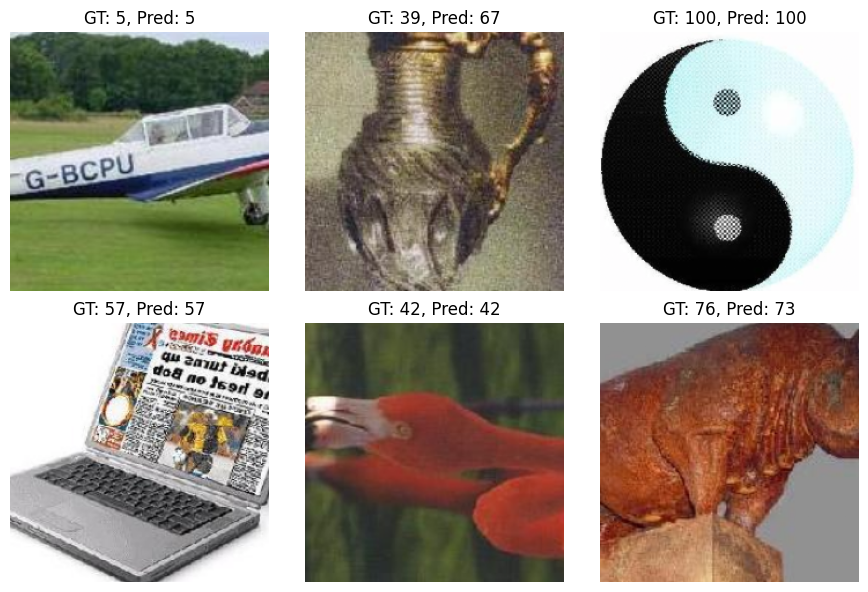

In [17]:
## testing loss

#Testing routine
def run_test_dataset(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy


run_test_dataset(frozen_resnet18, test_loader)


#Visualization pediction


def visualize_predictions(model, dataset, device, n_rows: int = 2, n_cols: int = 3):
    """
    Run inference on the first n_samples of a dataset and plot them
    with ground-truth (GT) and predicted (Pred) labels.

    Parameters
    ----------
    model : torch.nn.Module
        Trained PyTorch model.
    dataset : torch.utils.data.Dataset
        Dataset providing (image, label) pairs.
    device : torch.device
        Device to run inference on.
    n_rows : int, optional
        Number of rows, default = 2.
    n_cols : int, optional
        Number of cols, default = 3
    """
    model.eval()
    n_samples = n_rows * n_cols

    ### Your code here
    inputs, labels = [], []
    for i in range(n_samples):
        input, label = dataset[i]
        inputs.append(input)
        labels.append(label)

    with torch.no_grad():
        x_batch = torch.stack(inputs)
        x_batch = x_batch.to(device)
        logits = model(x_batch)
        preds = logits.argmax(dim=1).cpu().numpy()

    # Denormalize and move to CPU
    x_batch_cpu = denormalize(x_batch.cpu())

    plt.figure(figsize=(n_cols * 3, n_rows * 3))
    
    for i in range(n_samples):
        plt.subplot(n_rows, n_cols, i + 1)
        img = x_batch_cpu[i]
        img = img.permute(1,2,0).numpy()
        plt.imshow(img)
        plt.title(f"GT: {labels[i]}, Pred: {preds[i]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions(frozen_resnet18, test_dataset, device)


In [18]:
## ResNet18, transfer learning
## code
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet18.fc = nn.Linear(resnet18.fc.in_features, len(classes))
resnet18 = resnet18.to(device)
lr=1e-4
criterion, optimizer = get_loss_and_opt(resnet18, lr, 'ce')
save_path = "res18_best.pt"
train_model(resnet18, train_loader, val_loader, criterion, optimizer, save_path)


Epoch 01/5 | train loss 1.7999 acc 65.70% | val loss 0.6386 acc 87.47% 
  ↳ Saved new best to res18_best.pt
Epoch 02/5 | train loss 0.3749 acc 95.70% | val loss 0.3367 acc 93.39% 
  ↳ Saved new best to res18_best.pt
Epoch 03/5 | train loss 0.1132 acc 98.95% | val loss 0.2610 acc 94.93% 
  ↳ Saved new best to res18_best.pt
Epoch 04/5 | train loss 0.0449 acc 99.79% | val loss 0.2263 acc 95.77% 
  ↳ Saved new best to res18_best.pt
Epoch 05/5 | train loss 0.0305 acc 99.74% | val loss 0.2148 acc 95.47% 
  ↳ Saved new best to res18_best.pt


In [19]:
## testing loss
run_test_dataset(resnet18, test_loader)

Test Loss: 0.2624, Test Accuracy: 93.31%


(0.26241940287191695, 93.31283627978478)

#### ShuffleNet


In [32]:
## fine tuning shuffle Net
## repeat
frozen_shuffle = models.shufflenet_v2_x1_0(weights='DEFAULT')
for param in frozen_shuffle.parameters():
    param.requires_grad = False
frozen_shuffle.fc = nn.Linear(frozen_shuffle.fc.in_features, len(classes))
frozen_shuffle = frozen_shuffle.to(device)
print_model_weight_stats(frozen_shuffle)
lr=1e-3
criterion, optimizer = get_loss_and_opt(frozen_shuffle, lr, 'ce')
save_path = "frozen_shuffle_best.pt"

train_model(frozen_shuffle, train_loader, val_loader, criterion, optimizer, save_path)

<class 'torchvision.models.shufflenetv2.ShuffleNetV2'>: Number of fronzen param = 1,253,604, number of trainable param = 103,525
Epoch 01/5 | train loss 4.1283 acc 16.66% | val loss 3.7629 acc 24.29% 
  ↳ Saved new best to frozen_shuffle_best.pt


KeyboardInterrupt: 

In [21]:
## testing loss
run_test_dataset(frozen_shuffle, test_loader)

Test Loss: 4.1282, Test Accuracy: 20.37%


(4.128182451899459, 20.36894696387394)

In [22]:
## do a quick plot
## your code

In [31]:
## transfer learning of shuffleNet
##
## fine tuning shuffle Net
## repeat
shuffle = models.shufflenet_v2_x1_0(weights='DEFAULT')
shuffle.fc = nn.Linear(shuffle.fc.in_features, len(classes))
shuffle = shuffle.to(device)
print_model_weight_stats(shuffle)
lr = 1e-3
criterion, optimizer = get_loss_and_opt(shuffle, lr, 'ce')
save_path = "shuffle_best.pt"

train_model(shuffle, train_loader, val_loader, criterion, optimizer, save_path)

<class 'torchvision.models.shufflenetv2.ShuffleNetV2'>: Number of fronzen param = 0, number of trainable param = 1,357,129
Epoch 01/5 | train loss 3.0293 acc 34.34% | val loss 1.8512 acc 57.11% 
  ↳ Saved new best to shuffle_best.pt
Epoch 02/5 | train loss 1.2587 acc 67.34% | val loss 0.7456 acc 78.25% 
  ↳ Saved new best to shuffle_best.pt
Epoch 03/5 | train loss 0.5351 acc 85.25% | val loss 0.5940 acc 82.32% 
  ↳ Saved new best to shuffle_best.pt
Epoch 04/5 | train loss 0.2734 acc 92.48% | val loss 0.4728 acc 86.63% 
  ↳ Saved new best to shuffle_best.pt
Epoch 05/5 | train loss 0.1855 acc 94.68% | val loss 0.4644 acc 86.70% 
  ↳ Saved new best to shuffle_best.pt


In [24]:
## testing loss
run_test_dataset(shuffle, test_loader)

Test Loss: 2.3961, Test Accuracy: 42.97%


(2.396055369842343, 42.966948501152956)

In [25]:
## do a quick plot
## your code

#### You have to implement the third model

In [38]:
## frozen effnet
f_effnet = models.efficientnet_b0(weights='DEFAULT')
for param in f_effnet.parameters():
    param.requires_grad = False
f_effnet.classifier[1] = nn.Linear(f_effnet.classifier[1].in_features, len(classes))
f_effnet = f_effnet.to(device)
print_model_weight_stats(f_effnet)
lr = 1e-3
criterion, optimizer = get_loss_and_opt(f_effnet, lr, 'ce')
save_path = "f_effnet_best.pt"

train_model(f_effnet, train_loader, val_loader, criterion, optimizer, save_path)

<class 'torchvision.models.efficientnet.EfficientNet'>: Number of fronzen param = 4,007,548, number of trainable param = 129,381
Epoch 01/5 | train loss 1.8745 acc 67.14% | val loss 0.7510 acc 87.55% 
  ↳ Saved new best to f_effnet_best.pt
Epoch 02/5 | train loss 0.5351 acc 90.67% | val loss 0.4718 acc 89.78% 
  ↳ Saved new best to f_effnet_best.pt
Epoch 03/5 | train loss 0.3230 acc 93.74% | val loss 0.3739 acc 91.16% 
  ↳ Saved new best to f_effnet_best.pt
Epoch 04/5 | train loss 0.2394 acc 95.31% | val loss 0.3270 acc 91.70% 
  ↳ Saved new best to f_effnet_best.pt
Epoch 05/5 | train loss 0.1932 acc 96.21% | val loss 0.3117 acc 92.85% 
  ↳ Saved new best to f_effnet_best.pt


In [39]:
# transfer learning effnet
effnet = models.efficientnet_b0(weights='DEFAULT')
effnet.classifier[1] = nn.Linear(effnet.classifier[1].in_features, len(classes))
effnet = effnet.to(device)
print_model_weight_stats(effnet)
lr = 1e-3
criterion, optimizer = get_loss_and_opt(effnet, lr, 'ce')
save_path = "effnet_best.pt"

train_model(effnet, train_loader, val_loader, criterion, optimizer, save_path)


<class 'torchvision.models.efficientnet.EfficientNet'>: Number of fronzen param = 0, number of trainable param = 4,136,929
Epoch 01/5 | train loss 1.2255 acc 72.56% | val loss 0.4629 acc 86.63% 
  ↳ Saved new best to effnet_best.pt
Epoch 02/5 | train loss 0.3785 acc 89.20% | val loss 0.3647 acc 90.70% 
  ↳ Saved new best to effnet_best.pt
Epoch 03/5 | train loss 0.2301 acc 93.15% | val loss 0.3282 acc 91.39% 
  ↳ Saved new best to effnet_best.pt
Epoch 04/5 | train loss 0.1542 acc 95.34% | val loss 0.2731 acc 93.31% 
  ↳ Saved new best to effnet_best.pt
Epoch 05/5 | train loss 0.1064 acc 96.58% | val loss 0.3335 acc 92.24% 
no improvement for 1 epochs


In [40]:
run_test_dataset(effnet, test_loader)

Test Loss: 0.3837, Test Accuracy: 90.39%


(0.38372582369824737, 90.39200614911607)

#### Report the Pareto value here

In [ ]:
## for ResNet18, testing accuracy is for transfer learning
acc = 0.9547

## the model size is copied from print command
msize = 11228325.0/1000000

In [33]:
print("ResNet Pareto score is {:.4f}".format( compute_pareto_value(acc, msize)))

ResNet Pareto score is 0.0878


In [34]:
## for shufflenet
acc = 0.867
msize = 1357129.0/1000000

In [35]:
print("ShuffleNet pareto score is {:.4f}".format( compute_pareto_value(acc, msize)))

ShuffleNet pareto score is 0.1237


In [41]:
## for efficientnet
acc = 0.9039
msize = 4136929.0/1000000

In [42]:
print("EfficientNet pareto score is {:.4f}".format( compute_pareto_value(acc, msize)))

EfficientNet pareto score is 0.1059
